In [49]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch


In [50]:
r_img = cv2.imread('/mnt/d/Research/perceptual-reflection-removal/dataset/reflection_layer/9.jpg',-1)
t_img = cv2.imread('/mnt/d/Research/perceptual-reflection-removal/dataset/transmission_layer/9.jpg',-1)
t_img = cv2.cvtColor(t_img, cv2.COLOR_BGR2RGB)
r_img = cv2.cvtColor(r_img, cv2.COLOR_BGR2RGB)
t_img = cv2.resize(t_img, (64, 64))
r_img = cv2.resize(r_img, (64, 64))
r_img = torch.from_numpy(r_img.transpose((2, 0, 1))).float() / 255.0
t_img = torch.from_numpy(t_img.transpose((2, 0, 1))).float() / 255.0

In [ ]:
resSize = 64
t_h = torch.zeros(1,64*4 , resSize, resSize).to('cpu')
t_c = torch.zeros(1,64*4 , resSize, resSize).to('cpu')
r_h = torch.zeros(1,64*4 , resSize, resSize).to('cpu')
r_c = torch.zeros(1,64*4 , resSize, resSize).to('cpu')


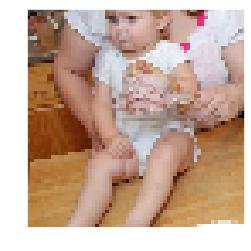

In [51]:
plt.imshow(t_img.detach().cpu().numpy().transpose(1, 2, 0))



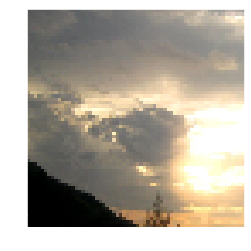

In [52]:
plt.imshow(r_img.detach().cpu().numpy().transpose(1, 2, 0))


In [53]:
t_img = t_img.pow(2.2)
r_img = r_img.pow(2.2)

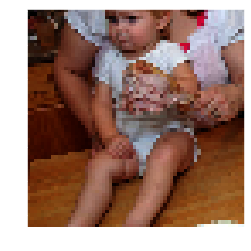

In [54]:
plt.imshow(t_img.detach().cpu().numpy().transpose(1, 2, 0))

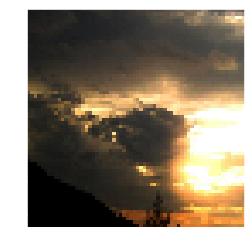

In [55]:
plt.imshow(r_img.detach().cpu().numpy().transpose(1, 2, 0))

In [56]:
k_sz=np.linspace(1,5,80)
print("k_sz",k_sz)
sigma=k_sz[np.random.randint(0, len(k_sz))]
print("sigma",sigma)

k_sz [1.         1.05063291 1.10126582 1.15189873 1.20253165 1.25316456
 1.30379747 1.35443038 1.40506329 1.4556962  1.50632911 1.55696203
 1.60759494 1.65822785 1.70886076 1.75949367 1.81012658 1.86075949
 1.91139241 1.96202532 2.01265823 2.06329114 2.11392405 2.16455696
 2.21518987 2.26582278 2.3164557  2.36708861 2.41772152 2.46835443
 2.51898734 2.56962025 2.62025316 2.67088608 2.72151899 2.7721519
 2.82278481 2.87341772 2.92405063 2.97468354 3.02531646 3.07594937
 3.12658228 3.17721519 3.2278481  3.27848101 3.32911392 3.37974684
 3.43037975 3.48101266 3.53164557 3.58227848 3.63291139 3.6835443
 3.73417722 3.78481013 3.83544304 3.88607595 3.93670886 3.98734177
 4.03797468 4.08860759 4.13924051 4.18987342 4.24050633 4.29113924
 4.34177215 4.39240506 4.44303797 4.49367089 4.5443038  4.59493671
 4.64556962 4.69620253 4.74683544 4.79746835 4.84810127 4.89873418
 4.94936709 5.        ]
sigma 3.3797468354430378


In [58]:
att = 1.08 + np.random.random() / 10.0
print('att',att)
alpha2 = 1 - np.random.random() / 5.0
print('alpha2',alpha2)
sz = int(2 * np.ceil(2 * sigma) + 1)
print('sz',sz)

att 1.1415586834859561
alpha2 0.8027424905085428
sz 15


In [61]:
import math
import torch.nn as nn
def get_gaussian_kernel(kernel_size=3, sigma=2, channels=3):
    # Create a x, y coordinate grid of shape (kernel_size, kernel_size, 2)
    x_coord = torch.arange(kernel_size)
    x_grid = x_coord.repeat(kernel_size).view(kernel_size, kernel_size)
    y_grid = x_grid.t()
    xy_grid = torch.stack([x_grid, y_grid], dim=-1).float()

    mean = (kernel_size - 1) / 2.
    variance = sigma ** 2.

    # Calculate the 2-dimensional gaussian kernel which is
    # the product of two gaussian distributions for two different
    # variables (in this case called x and y)
    gaussian_kernel = (1. / (2. * math.pi * variance)) * \
                      torch.exp(
                          -torch.sum((xy_grid - mean) ** 2., dim=-1) / \
                          (2 * variance)
                      )

    # Make sure sum of values in gaussian kernel equals 1.
    gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)

    # Reshape to 2d depthwise convolutional weight
    gaussian_kernel = gaussian_kernel.view(1, 1, kernel_size, kernel_size)
    gaussian_kernel = gaussian_kernel.repeat(channels, 1, 1, 1)

    paddingl = (kernel_size - 1) // 2
    paddingr = kernel_size - 1 - paddingl
    pad = torch.nn.ReflectionPad2d((paddingl, paddingr, paddingl, paddingr))
    gaussian_filter = nn.Conv2d(in_channels=channels, out_channels=channels,
                                kernel_size=kernel_size, groups=channels, bias=False)

    gaussian_filter.weight.data = gaussian_kernel
    gaussian_filter.weight.requires_grad = False

    return nn.Sequential(pad, gaussian_filter)

In [64]:
r_img.size()

torch.Size([3, 64, 64])

torch.Size([3, 64, 64])


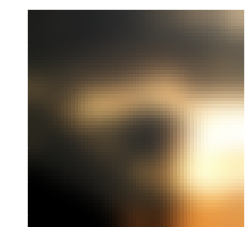

In [70]:
g_kernel = get_gaussian_kernel(sz, sigma)
g_kernel = g_kernel.to('cpu')
r_blur: torch.Tensor = g_kernel(r_img.unsqueeze(0)).float()
print(r_blur.squeeze(0).size())
plt.imshow(r_blur.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0))


In [73]:
blend: torch.Tensor = r_blur + t_img
print(blend.size())


torch.Size([1, 3, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


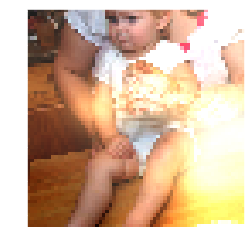

In [74]:
plt.imshow(blend.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0))


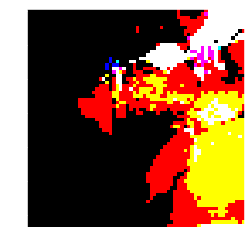

In [78]:
maski = (blend > 1).float()
plt.imshow(maski.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0))

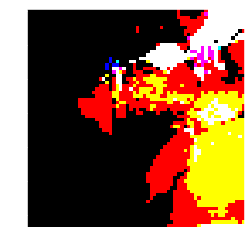

In [79]:
mean_i = torch.clamp(torch.sum(blend * maski, dim=(2, 3)) / (torch.sum(maski, dim=(2, 3)) + 1e-6),
                        min=1).unsqueeze_(-1).unsqueeze_(-1)
plt.imshow(maski.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


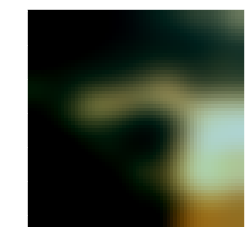

In [80]:
r_blur = r_blur - (mean_i - 1) * att
plt.imshow(r_blur.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0))

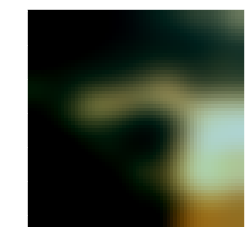

In [81]:
r_blur = r_blur.clamp(min=0, max=1)
plt.imshow(r_blur.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0))

In [83]:
from scipy import stats as st
def gkern(kernlen=100, nsig=1):
    """Returns a 2D Gaussian kernel array."""
    interval = (2 * nsig + 1.) / (kernlen)
    x = np.linspace(-nsig - interval / 2., nsig + interval / 2., kernlen + 1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw / kernel_raw.sum()
    kernel = kernel / kernel.max()
    return kernel


# create a vignetting mask
g_mask = gkern(560, 3)
g_mask = np.dstack((g_mask, g_mask, g_mask))
g_mask = torch.tensor(g_mask.transpose(2, 0, 1)).to('cpu')

In [84]:
h, w = r_blur.shape[2:4]
neww = np.random.randint(0, 560 - w - 10)
newh = np.random.randint(0, 560 - h - 10)
alpha1 = g_mask[:, newh:newh + h, neww:neww + w].unsqueeze_(0)

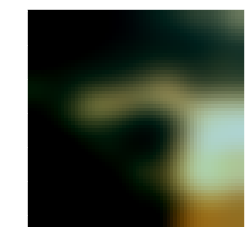

In [85]:
r_blur_mask = r_blur * alpha1
plt.imshow(r_blur.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0))

In [17]:
att=1.08+np.random.random()/10.0
print(att)

1.0983944624490751


In [ ]:
blend = r_blur_mask + t * alpha2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


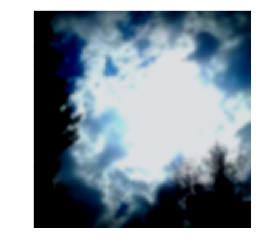

In [18]:
for i in range(3):
    maski=blend[:,:,i]>1
    mean_i=max(1.,np.sum(blend[:,:,i]*maski)/(maski.sum()+1e-6))
    r_blur[:,:,i]=r_blur[:,:,i]-(mean_i-1)*att
plt.imshow(r_blur)


In [19]:
h,w=r_blur.shape[0:2]
print(h,w)
nneww=np.random.randint(0, 560-w-10)
nnewh=np.random.randint(0, 560-h-10)
print(nneww,nnewh)

365 365
3 115


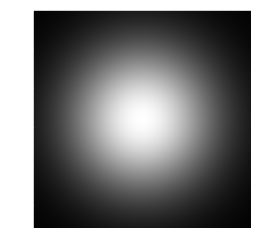

In [20]:
import scipy.stats as st
def gkern(kernlen=100, nsig=1):
    """Returns a 2D Gaussian kernel array."""
    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    kernel = kernel/kernel.max()
    return kernel

# create a vignetting mask
g_mask=gkern(560,3)
plt.imshow(g_mask)
g_mask=np.dstack((g_mask,g_mask,g_mask))
plt.imshow(g_mask)


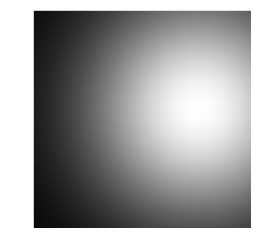

In [21]:
alpha1=g_mask[nnewh:nnewh+h,nneww:nneww+w,:]
plt.imshow(alpha1)


In [22]:
alpha2 = 1-np.random.random()/5.0;
print(alpha2)


0.9225210045562571


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


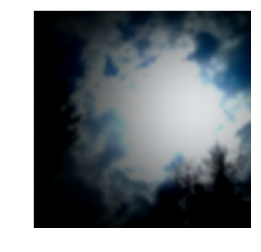

In [23]:
r_blur_mask=np.multiply(r_blur,alpha1)
plt.imshow(r_blur_mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


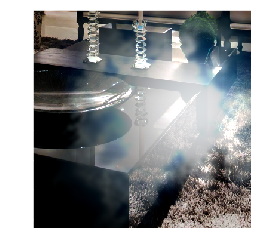

In [24]:
blend=r_blur_mask+t*alpha2
plt.imshow(blend)

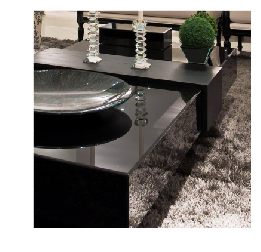

In [25]:
t=np.power(t,1/2.2)
plt.imshow(t)

/home/pol/miniconda3/envs/PRR/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in power
  """Entry point for launching an IPython kernel.


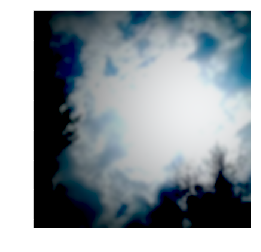

In [26]:
r_blur_mask=np.power(r_blur_mask,1/2.2)
plt.imshow(r_blur_mask)

/home/pol/miniconda3/envs/PRR/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in power
  """Entry point for launching an IPython kernel.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


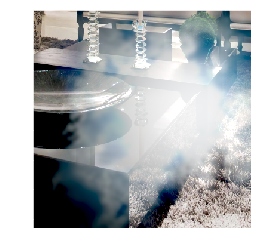

In [27]:
blend=np.power(blend,1/2.2)
plt.imshow(blend)

/home/pol/miniconda3/envs/PRR/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater_equal
  """Entry point for launching an IPython kernel.


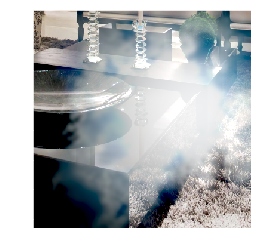

In [28]:
blend[blend>=1]=1
plt.imshow(blend)

/home/pol/miniconda3/envs/PRR/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less_equal
  """Entry point for launching an IPython kernel.


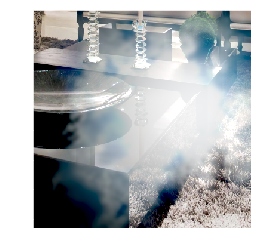

In [29]:
blend[blend<=0]=0
plt.imshow(blend)

In [30]:
blend=np.power(blend,1/2.2)
blend[blend>=1]=1
blend[blend<=0]=0

/home/pol/miniconda3/envs/PRR/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater_equal
  
/home/pol/miniconda3/envs/PRR/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less_equal
  This is separate from the ipykernel package so we can avoid doing imports until


In [31]:
# t=np.power(output_image_t,2.2)
# r=np.power(output_image_t,2.2)

# sz=int(2*np.ceil(2*sigma)+1)
# r_blur=cv2.GaussianBlur(r,(sz,sz),sigma,sigma,0)
# blend=r_blur+t

# att=1.08+np.random.random()/10.0

# for i in range(3):
#     maski=blend[:,:,i]>1
#     mean_i=max(1.,np.sum(blend[:,:,i]*maski)/(maski.sum()+1e-6))
#     r_blur[:,:,i]=r_blur[:,:,i]-(mean_i-1)*att
# r_blur[r_blur>=1]=1
# r_blur[r_blur<=0]=0

# h,w=r_blur.shape[0:2]
# neww=np.random.randint(0, 560-w-10)
# newh=np.random.randint(0, 560-h-10)
# alpha1=g_mask[newh:newh+h,neww:neww+w,:]
# alpha2 = 1-np.random.random()/5.0;
# r_blur_mask=np.multiply(r_blur,alpha1)
# blend=r_blur_mask+t*alpha2

# t=np.power(t,1/2.2)
# r_blur_mask=np.power(r_blur_mask,1/2.2)
# blend=np.power(blend,1/2.2)
# blend[blend>=1]=1
# blend[blend<=0]=0